In [3]:
!pip install yfinance pandas numpy matplotlib tensorflow


In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [5]:
# Download stock data from Yahoo Finance
stock_data = yf.download("AAPL", start="2015-01-01", end="2023-01-01")

# Display the first few rows
stock_data.head()


[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2015-01-02,24.347172,27.332500,27.860001,26.837500,27.847500,212818400
2015-01-05,23.661270,26.562500,27.162500,26.352501,27.072500,257142000
2015-01-06,23.663496,26.565001,26.857500,26.157499,26.635000,263188400
2015-01-07,23.995317,26.937500,27.049999,26.674999,26.799999,160423600
2015-01-08,24.917269,27.972500,28.037500,27.174999,27.307501,237458000


In [6]:
# Use the 'Close' column for predictions
closing_prices = stock_data['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)


In [7]:
# 80% training, 20% testing
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]


Prepare input-output pairs for the LSTM model.

In [8]:
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

time_step = 60  # Use the past 60 days to predict the next day
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape for LSTM input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [9]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
history = model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_test, y_test))


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.0224 - val_loss: 0.0151
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 8.7572e-04 - val_loss: 0.0024
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 9.2171e-04 - val_loss: 0.0038
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - loss: 9.1400e-04 - val_loss: 0.0017
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 8.5909e-04 - val_loss: 0.0022
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 8.3838e-04 - val_loss: 0.0028
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 7.3131e-04 - val_loss: 0.0021
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━

In [13]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Undo normalization


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


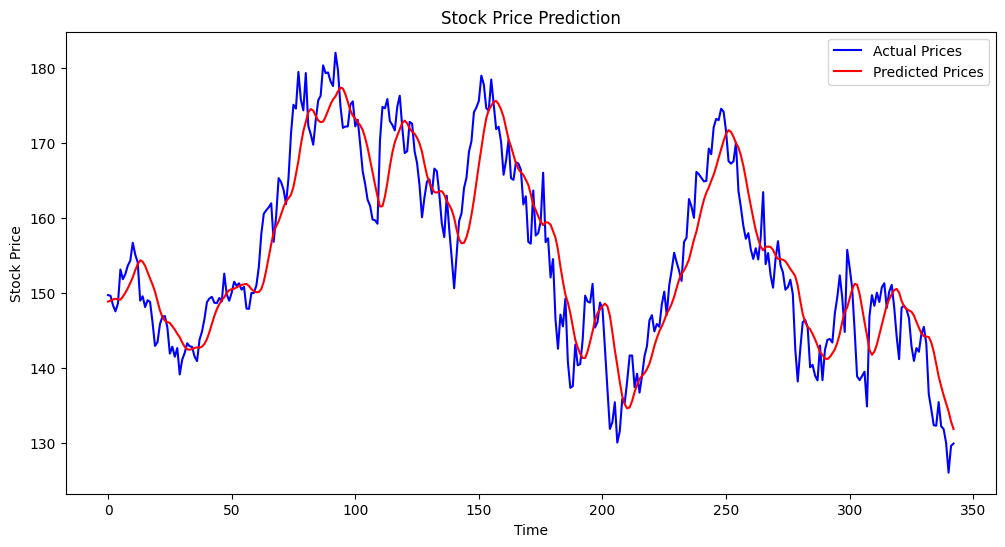

In [14]:
# Undo normalization for y_test
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label="Actual Prices", color='blue')
plt.plot(predictions, label="Predicted Prices", color='red')
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Stock Price Prediction")
plt.legend()
plt.show()


In [15]:
model.save("stock_price_predictor.h5")


In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(actual_prices, predictions)
mae = mean_absolute_error(actual_prices, predictions)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")


Mean Squared Error: 25.990316596796696
Mean Absolute Error: 4.051632427960721


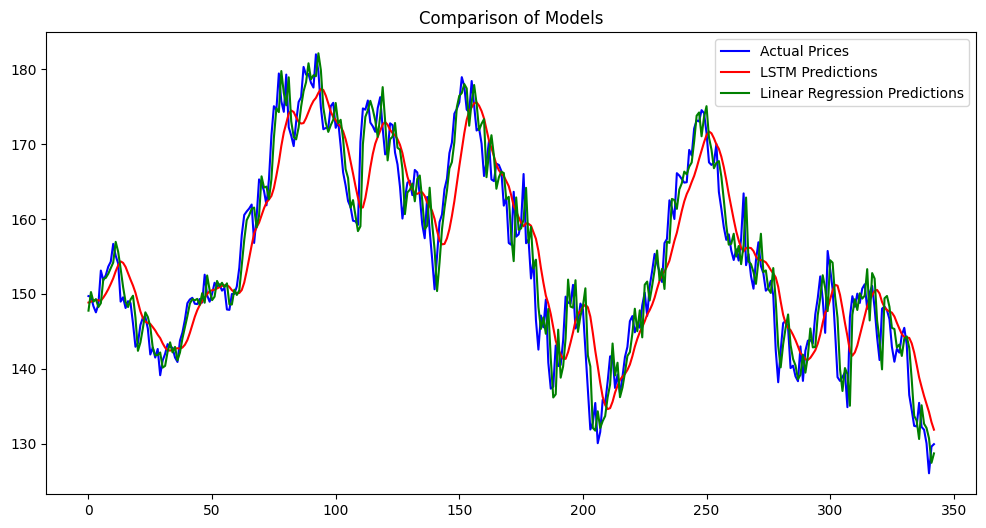

In [17]:
from sklearn.linear_model import LinearRegression

# Use the same training and testing data (flattened)
lr = LinearRegression()
X_train_flat = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test_flat = X_test.reshape(X_test.shape[0], X_test.shape[1])

lr.fit(X_train_flat, y_train)
lr_predictions = lr.predict(X_test_flat)

# Reverse normalization
lr_predictions = scaler.inverse_transform(lr_predictions.reshape(-1, 1))

# Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label="Actual Prices", color='blue')
plt.plot(predictions, label="LSTM Predictions", color='red')
plt.plot(lr_predictions, label="Linear Regression Predictions", color='green')
plt.title("Comparison of Models")
plt.legend()
plt.show()


In [20]:
!pip install keras-tuner
from keras_tuner.tuners import RandomSearch

def build_model(hp):
    model = Sequential([
        LSTM(hp.Int('units', min_value=32, max_value=128, step=16),
             return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(0.2),
        LSTM(hp.Int('units', min_value=32, max_value=128, step=16)),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='my_dir',
    project_name='stock_prediction_tuning'
)

tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps)


Trial 5 Complete [00h 01m 38s]
val_loss: 0.0013891691341996193

Best val_loss So Far: 0.0013745162868872285
Total elapsed time: 00h 06m 49s


I am using Gradio to create an interactive demo where users can input a stock ticker and date range:


In [23]:
!pip install gradio

import gradio as gr

def predict_stock(ticker, start_date, end_date):
    # Fetch stock data
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    closing_prices = stock_data['Close'].values.reshape(-1, 1)
    scaled_data = scaler.transform(closing_prices)

    # Prepare data for LSTM
    last_sequence = scaled_data[-time_step:]
    input_data = last_sequence.reshape(1, time_step, 1)
    next_price = model.predict(input_data)[0][0]

    return f"Predicted next closing price: ${scaler.inverse_transform([[next_price]])[0][0]:.2f}"

demo = gr.Interface(
    fn=predict_stock,
    inputs=["text", "text", "text"],
    outputs="text",
    title="Stock Price Predictor"
)
demo.launch()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b53e2f70711325b3ea.gradio.live

This share link expires in 72 hours.